Решить краевую задачу для дифференциального уравнения эллиптического типа. Аппроксимацию уравнения произвести с использованием центрально-разностной схемы. Для решения дискретного аналога применить следующие методы: метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией. Вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,y)$.  Исследовать зависимость погрешности от сеточных параметров $h_x$, $h_y$.

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + u = 0 $$
$ u_x(0, y) = y \\ u_x(\frac{\pi}{2}, y) = 0 \\ u(x, 0) = 0 \\ u(x, 1) = sin(x) $

$$ U(x, y) = y sin(x)$$

In [211]:
import math
import typing
from typing import List
import matplotlib.pyplot as plt
import copy

### Входные условия

In [212]:
x_left = 0
x_right = math.pi/2
y_left = 0
y_right = 1
a = 1
b = 1
c = 1
d = 0
alpha_1, betta_1 = 1, 0
alpha_2, betta_2 = 1, 0
alpha_3, betta_3 = 0, 1
alpha_4, betta_4 = 0, 1

In [213]:
def phi_1(y:float) -> float:
    return y

def phi_2(y:float) -> float:
    return 0

def phi_3(x:float) -> float:
    return 0

def phi_4(x:float) -> float:
    return math.sin(x)

def f(x:float, y:float) -> float:
    return 0

def U(x:float, y:float) -> float:
    return y * math.sin(x)

def real_U(X:list, Y:list) -> list:
    n = len(X)
    m = len(Y)
    U_true = [[0] * n for _ in range(m)]
    for k in range(m):
        for j in range(n):
            U_true[k][j] = U(X[j], Y[k])
    return U_true

### Вспомогательные функиции

графики

In [214]:

def plot_graphs(new_X:list, new_T:list, found_U:list, U_true:list, s:str='') -> None:
    plt.plot(new_X, U_true[len(new_T) // 4 ],  label='Аналитическое решение')
    plt.plot(new_X, found_U[len(new_T) // 4 ], label=s, linestyle='dashdot')
    plt.plot(new_X, U_true[len(new_T) // 2 ], label='Аналитическое решение')
    plt.plot(new_X, found_U[len(new_T) // 2 ], label=s, linestyle='dashdot')
    plt.plot(new_X, U_true[len(new_T) - 1], label='Аналитическое решение')
    plt.plot(new_X, found_U[len(new_T) - 1],label=s, linestyle='dashdot')
    plt.legend()

график ошибки от h

In [215]:
def local_error (U_my:list, U_true:list) -> float:
    return sum([abs(a - b) for a, b in zip(U_my, U_true)])

def get_error_array_with_h(N:list, x_left:float, x_right:float, y_left:float, y_right:float, a:float, b:float, c:float, d:float, 
                           find_u:typing.Callable, eps:float=0.1, n_x:float=10, n_y:float=10, omega:float=-10, for_x:bool=True)  -> (list, list): # H, error
    
    if for_x:
        right = x_right
    else:
        right = y_right
    H = [right/(n - 1) for n in N]
    ERROR = []
    for n in N:
        if omega == -10:
            if for_x:
                XX, YY, UU = find_u(x_left, x_right, y_left, y_right, a, b, c, d, eps=eps, n_x=n, n_y=n_y)
            else:
                XX, YY, UU = find_u(x_left, x_right, y_left, y_right, a, b, c, d, eps=eps, n_x=n_x, n_y=n)
        else:
            if for_x:
                XX, YY, UU = find_u(x_left, x_right, y_left, y_right, a, b, c, d=0, eps=eps, n_x=n, n_y=n_y, omega=omega)
            else:
                XX, YY, UU = find_u(x_left, x_right, y_left, y_right, a, b, c, d=0, eps=eps, n_x=n_x, n_y=n, omega=omega)
        U_true = real_U(XX, YY)
        t = len(YY) // 2
        ERROR.append(local_error(UU[t], U_true[t]))
    
    return H, ERROR

In [216]:
def h_error_plot(H:list, ERROR:list, s:str=' x') -> None:
    plt.plot(H, ERROR[::-1])
    plt.xlabel("h" + s)
    plt.ylabel("error")
    plt.show()

In [217]:
def frange(start:float, stop:float, step:float) -> float:
    while start < stop:
        yield start
        start += step

In [218]:
def get_y(y0:float, y_end:float, h:float) -> list:
    return [i for i in frange(y0, y_end+h, h)]

def get_x(x_0:float, x_l:float, h:float) -> list:
    return [i for i in frange(x_0, x_l+h, h)]

In [219]:
def avg(N:List[int]) -> int:
    return sum(N) / (len(N))

In [220]:
def interpol(U_values:List[List[float]], X:List[float], Y:List[float], y_right:float) -> None:
    for i in range(1, len(Y) - 1):
        for j in range(1, len(X) - 1):
            alpha = Y[i] / y_right
            U_values[i][j] = phi_2(X[j]) * (1 - alpha) + phi_1(X[j]) * alpha
        
def border_conds(U_values:List[List[float]], X:List[float], Y:List[float]) -> None:
    for i in range(len(Y)):
        U_values[i][0] = phi_2(Y[i])
        U_values[i][-1] = phi_1(Y[i])
    for i in range(len(X)):
        U_values[0][i] = phi_3(X[i])
        U_values[-1][i] = phi_4(X[i])

Отношение конечной разности по схеме

$$\frac{u_{i+1, j} - 2 u_{i, j} + u_{i-1, j}}{h_1^2}  + \frac{u_{i, j+1} - 2 u_{i, j} + u_{i, j-1}}{h_2^2} + O(h_1^2 + h_2^2) = f(x_i, y_i)$$

мой случай 
$$ \frac{u_{i+1, j} - 2 u_{i, j} + u_{i-1, j}}{h_1^2}  +  \frac{u_{i, j+1} - 2 u_{i, j} + u_{i, j-1}}{h_2^2} + c u_{i, j} = f(x_i, y_i) $$

### Метод Лимбмана

$$ u^{k+1}_{i, j} = \left(\frac{u^k_{i-1, j} + u^k_{i+1, j}}{h_1^2} + \frac{u^k_{i, j-1} + u^k_{i, j+1}}{h_2^2} + с u^k_{i, j} + f_{i, j}\right) \left(\frac{2}{h_1^2} + \frac{2}{h_2^2}\right)^{-1}$$

In [221]:
def error(U_prev:List[List[float]], U_values:List[List[float]]) -> float:
    eps = 0
    for i in range(len(U_values)):
        for j in range(len(U_values[0])):
            eps = max(eps, abs(U_prev[i][j] - U_values[i][j]))
    return eps

def limbman(x_left:float, x_right:float, y_left:float, y_right:float, a:float, b:float, c:float, d:float=0, eps:float=0.1, n_x:float=10, n_y:float=10) -> (List[float], List[float], List[List[float]]):
    hx = x_right / (n_x - 1)
    hy = y_right / (n_y - 1)
    X = get_x(x_left, x_right, hx)
    Y = get_y(y_left, y_right, hy)

    U_values = [[0.0] * len(X) for _ in range(len(Y))]
    U_prev = [[10.0] * len(X) for _ in range(len(Y))]
    border_conds(U_values, X, Y)
    interpol(U_values, X, Y, y_right)

    cnt = 0
    while (error(U_prev, U_values) > eps):

        U_prev = copy.deepcopy(U_values)

        for i in range(1, len(Y) - 1):
            for j in range(1, len(X) - 1):


                U_values[i][j] = ((U_prev[i-1][j] +  U_prev[i+1][j]) / hx**2 + (U_prev[i][j-1] + U_prev[i][j+1]) / hy**2  + c * U_prev[i][j] - f(X[j], Y[i])) * ((hx**2 * hy**2) / (2 * (hx**2 + hy**2)))
        cnt +=1

    print('Iterations', cnt)
    return X, Y, U_values

Iterations 203


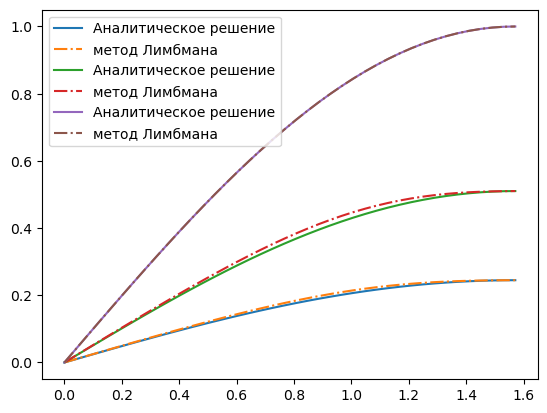

In [222]:
X, Y, UU = limbman(x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.0005, n_x=40, n_y=50)
U_true = real_U(X, Y)
plot_graphs(X, Y, UU, U_true, 'метод Лимбмана')

In [223]:
N = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

Iterations 65
Iterations 164
Iterations 217
Iterations 218
Iterations 221
Iterations 237
Iterations 244
Iterations 244
Iterations 251
Iterations 265


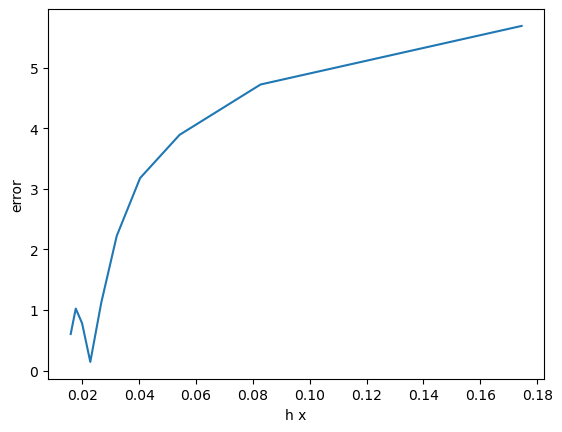

In [224]:
H_X1, ERROR_X1 = get_error_array_with_h(N, x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.0005, n_x=20, n_y=avg(N), find_u=limbman)
h_error_plot(H_X1, ERROR_X1)

Iterations 62
Iterations 169
Iterations 196
Iterations 202
Iterations 220
Iterations 241
Iterations 251
Iterations 259
Iterations 262
Iterations 271


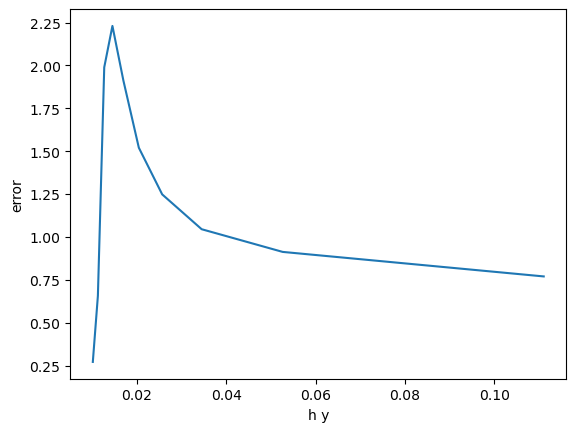

In [240]:
H_Y1, ERROR_Y1 = get_error_array_with_h(N, x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.0005, n_x=avg(N), n_y=20, for_x=False, find_u=limbman)
h_error_plot(H_Y1, ERROR_Y1, s=' y')

### Метод Зейделя

In [226]:
def Seidel(x_left:float, x_right:float, y_left:float, y_right:float, a:float, b:float, c:float, d:float=0, eps:float=0.1, n_x:float=10, n_y:float=10) -> (List[float], List[float], List[List[float]]):
    hx = x_right / (n_x - 1)
    hy = y_right / (n_y - 1)
    X = get_x(x_left, x_right, hx)
    Y = get_y(y_left, y_right, hy)

    U_values = [[0.0] * len(X) for _ in range(len(Y))]
    U_prev = [[10.0] * len(X) for _ in range(len(Y))]

    border_conds(U_values, X, Y)
    interpol(U_values, X, Y, y_right)

    cnt = 0
    while (error(U_prev, U_values) > eps):
        U_prev = copy.deepcopy(U_values)
        for i in range(1, len(Y) - 1):
            for j in range(1, len(X) - 1):
                U_values[i][j] = ((U_values[i-1][j] +  U_values[i+1][j]) / hx**2 + (U_values[i][j-1] + U_values[i][j+1]) / hy**2 + c * U_values[i][j] - f(X[j], Y[i])) * ((hx**2 * hy**2) / (2 * (hx**2 + hy**2)))
        cnt += 1
    print('Iterations', cnt)
    return X, Y, U_values
    

Iterations 183


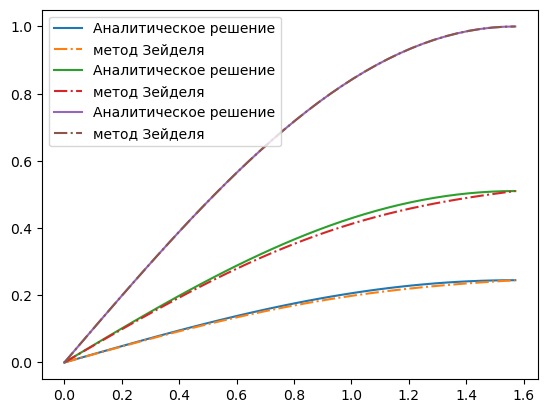

In [227]:
X2, Y2, UU2 = Seidel(x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.0005, n_x=40, n_y=50)
U_true2 = real_U(X2, Y2)
plot_graphs(X2, Y2, UU2, U_true2, 'метод Зейделя')

In [228]:
N = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

Iterations 39
Iterations 113
Iterations 176
Iterations 198
Iterations 196
Iterations 206
Iterations 210
Iterations 211
Iterations 218
Iterations 230


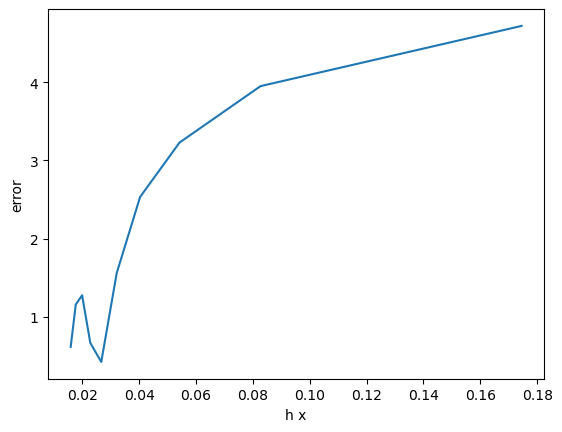

In [229]:
H_X2, ERROR_X2 = get_error_array_with_h(N, x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.0005, n_x=20, n_y=avg(N), find_u=Seidel)
h_error_plot(H_X2, ERROR_X2)

Iterations 40
Iterations 121
Iterations 159
Iterations 168
Iterations 189
Iterations 213
Iterations 228
Iterations 240
Iterations 246
Iterations 257


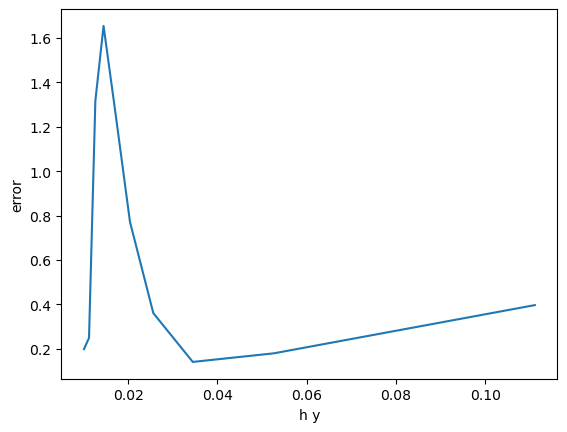

In [239]:
H_Y2, ERROR_Y2 = get_error_array_with_h(N, x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.0005, n_x=avg(N), n_y=20, for_x=False, find_u=Seidel)
h_error_plot(H_Y2, ERROR_Y2, s=' y')

### Метод простых итераций с верхней релаксацией

In [231]:
def relax(x_left:float, x_right:float, y_left:float, y_right:float, a:float, b:float, c:float, d:float=0, eps:float=0.1, n_x:float=10, n_y:float=10, omega:float=1.5) -> (List[float], List[float], List[List[float]]):
    hx = x_right / (n_x - 1)
    hy = y_right / (n_y - 1)
    X = get_x(x_left, x_right, hx)
    Y = get_y(y_left, y_right, hy)

    U_values = [[0] * len(X) for _ in range(len(Y))]
    U_prev = [[10] * len(X) for _ in range(len(Y))]

    border_conds(U_values, X, Y)
    interpol(U_values, X, Y, y_right)


    cnt = 0
    while (error(U_prev, U_values) > eps):
        U_prev = copy.deepcopy(U_values)
        for i in range(1, len(Y) - 1):
            for j in range(1, len(X) - 1):
                U_values[i][j] = ((U_values[i-1][j] +  U_prev[i+1][j]) / hx**2 + (U_values[i][j-1] + U_prev[i][j+1]) / hy**2 + c * U_values[i][j] - f(X[j], Y[i])) * ((hx**2 * hy**2) / (2 * (hx**2 + hy**2)))
                U_values[i][j] = omega * U_values[i][j] + (1 - omega) * U_prev[i][j]
        cnt += 1
    print('Iterations', cnt)
    return X, Y, U_values

Iterations 369


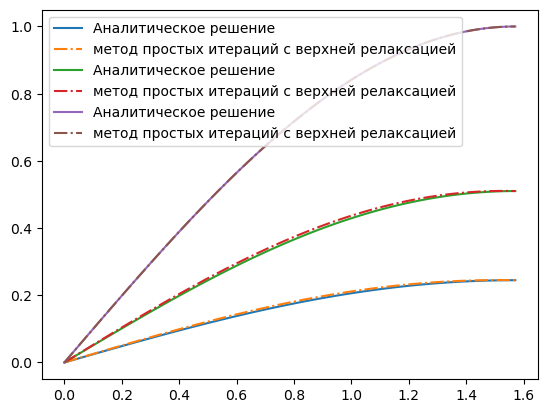

In [232]:
X3, Y3, UU3 = relax(x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.00005, n_x=80, n_y=50)
U_true3 = real_U(X3, Y3)
plot_graphs(X3, Y3, UU3, U_true3, 'метод простых итераций с верхней релаксацией')

In [233]:
N = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

Iterations 15
Iterations 54
Iterations 97
Iterations 133
Iterations 149
Iterations 153
Iterations 152
Iterations 151
Iterations 156
Iterations 166


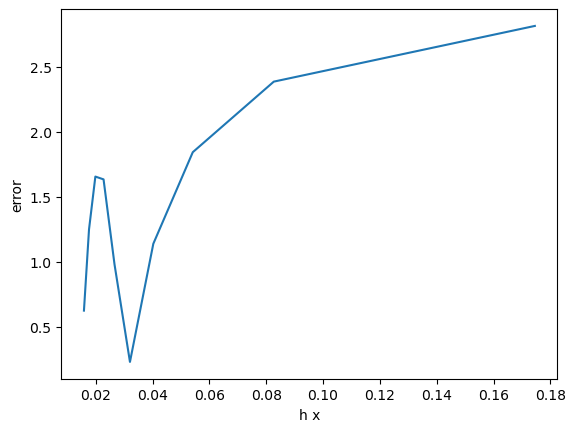

In [234]:
H_X3, ERROR_X3 = get_error_array_with_h(N, x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.0005, n_x=20, n_y=avg(N), omega=1.5, find_u=relax)
h_error_plot(H_X3, ERROR_X3)

Iterations 16
Iterations 62
Iterations 98
Iterations 115
Iterations 138
Iterations 164
Iterations 179
Iterations 189
Iterations 194
Iterations 201


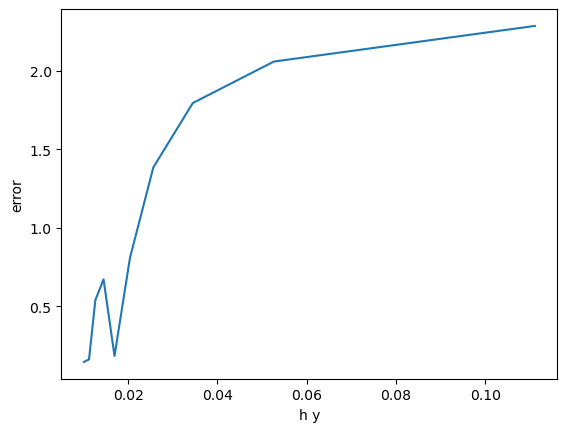

In [235]:
H_Y3, ERROR_Y3 = get_error_array_with_h(N, x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.0005, n_x=avg(N), n_y=20, for_x=False, omega=1.5, find_u=relax)
h_error_plot(H_Y3, ERROR_Y3, s=' y')